<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/01-banners_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.stats import beta
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Apply the default theme
sns.set_theme()

## Environment
- Test

In [ ]:
class BannerEnvironment(object):
  def __init__(self, ctrs: List[int]):
    self.ctrs = ctrs
    self._observe()

  def reset(self):
    return self._observe()

  def _observe(self) -> List[float]:
    self._observation = np.random.rand(1)
    return self._observation

  def step(self, action: int) -> Tuple[int, float]:
    self._observe()
    #print(f' - observation={self._observation[0]}, ctr={self.ctrs[action]}')
    return (
        int(self.ctrs[action] > self._observation[0]), 
        self._observation[0])
    
    

In [ ]:
env = BannerEnvironment([0.25, 0.4, 0.67])

observation = env.reset()
print(f'observation: {observation}')

action =  2#@param
print(f'action: {action}')

ret = env.step(action)
print(f'reward: {ret[0]}')

observation: [0.8981948]
action: 2
reward: 1


## Policy

In [ ]:
class BetaPolicy(object):
  def __init__(self, alpha: List[int], beta: List[int]):
    self._alpha = alpha
    self._beta = beta
  
  def action(self) -> int:
    sample = np.random.beta(self._alpha, self._beta)
    #print(' - sample', sample, self._alpha, self._beta)
    return np.argmax(sample)

In [ ]:
pol = BetaPolicy([1, 10, 5], [1, 1, 1])
action = pol.action()
print(f'action: {action}')

action: 1


## Agent

In [ ]:
class BannerAgent(object):
  def __init__(self):
    self._alpha = [1, 1, 1]
    self._beta = [1, 1, 1]

    self.policy = BetaPolicy(self._alpha, self._beta)

  def train(self, experience: Dict[str, int]):
    action = experience['action']
    reward = experience['reward']

    if reward == 1:
      self._alpha[action] += 1
    else:
      self._beta[action] += 1


## Utils

In [ ]:
def plot_pdf(a: List[int], b: List[int]):
  plt.figure(figsize=(10, 7))
  x = np.linspace(beta.ppf(0.01, a, b),
                  beta.ppf(0.99, a, b), 100)

  lines = plt.plot(x, beta.pdf(x, a, b), '-', lw=1, alpha=0.6, label='beta pdf')

  #lines = ax.plot(x,y.T[:,:])
  plt.legend(lines, [f'action={j}' for j in range(len(lines))])  

  plt.xlabel('x')
  plt.ylabel('PDF')
  plt.show()
  

def plot_cumsum(df: pd.DataFrame, show_actions=False):
  plt.figure(figsize=(10, 7))

  if show_actions:
    df_actions = df.groupby(['trial', 'action']).mean().reset_index()

    for action in sorted(df.action.unique()):
      plt.plot(
          df_actions[df_actions['action']==action].trial, 
          df_actions[df_actions['action']==action].action_cum_sum,
          label=f'action={int(action)} cumulative reward'
      )

  df_all = df.groupby('trial')['cum_sum'].mean().reset_index()
  plt.plot(df_all.trial, df_all.cum_sum, label='agent cumulative reward')

  plt.xlim(0)
  plt.xlabel('Number of trials')
  plt.ylabel('Cumulative Reward')
  plt.legend()
  #plt.title(f'Cumulative Reward of the {algorithm_name} Algorithm')
  plt.show()

In [ ]:
np.random.random_sample(3)

array([0.80186881, 0.86360365, 0.35433043])

## Experiment

In [ ]:
def run(environment: object, agent: object, trials=100):
  columns = ['trial', 'action', 'observation', 'reward']
  df_trajectory = pd.DataFrame(columns=columns, dtype=float)

  experience = {'trial': 0, 'action': -1, 'observation': 0, 'reward': 0}

  for i in range(trials):
    experience['trial'] = i + 1
    experience['action'] = agent.policy.action()
    experience['reward'], experience['observation'] = environment.step(experience['action'])

    agent.train(experience)

    df_trajectory = df_trajectory.append(experience, ignore_index=True)

  df_cumsum = df_trajectory.groupby('action')['reward'].cumsum()
  df_trajectory = df_trajectory.assign(cum_sum=df_trajectory['reward'].cumsum())
  df_trajectory = df_trajectory.assign(action_cum_sum=df_cumsum)

  return df_trajectory

In [ ]:
environment = BannerEnvironment([0.25, 0.4, 0.67])
step = environment.reset()

agent = BannerAgent()

df_trajectory = run(environment, agent, trials=1000)

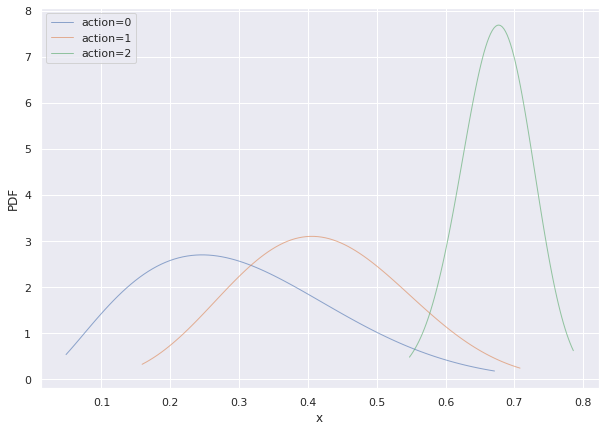

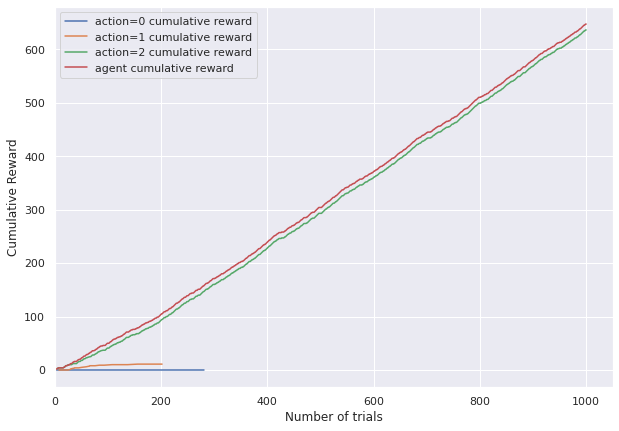

In [ ]:
plot_pdf(np.array(params['alpha']).mean(axis=0), np.array(params['beta']).mean(axis=0))
plot_cumsum(df_trajectory, show_actions=True)

### Epochs

In [ ]:
def experiment(epochs: int = 1, trials: int = 10):
  columns = ['trial', 'action', 'observation', 'reward']
  df_trajectory = pd.DataFrame(columns=columns, dtype=float)

  params = {
    'alpha': [],
    'beta': []  
  }

  for epoch in range(epochs):
    environment = BannerEnvironment([0.25, 0.4, 0.67])
    step = environment.reset()
    agent = BannerAgent()

    df = run(environment, agent, trials=trials)

    df_trajectory = df_trajectory.append(df, ignore_index=True)

    params['alpha'].append(agent._alpha)
    params['beta'].append(agent._beta)

  return df_trajectory, params

In [ ]:
df_trajectory, params = experiment(epochs=100, trials=1000)

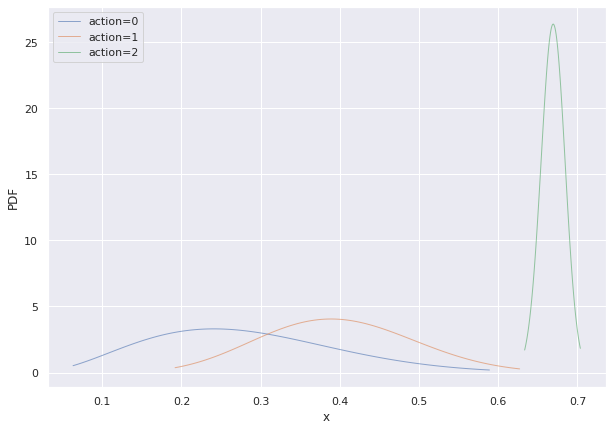

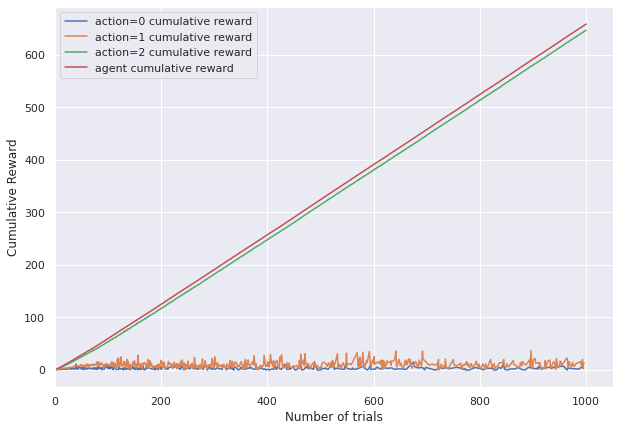

In [ ]:
plot_pdf(np.array(params['alpha']).mean(axis=0), np.array(params['beta']).mean(axis=0))
plot_cumsum(df_trajectory, show_actions=True)

### Change of the environment

In [ ]:
environment = BannerEnvironment([0.25, 0.4, 0.67])
step = environment.reset()

agent = BannerAgent()

df_trajectory = run(environment, agent, trials=100)

print(f'\nalpha={agent._alpha}, beta={agent._beta}')
print(f'mu={beta.stats(agent._alpha, agent._beta)[0]}')


alpha=[1, 13, 50], beta=[5, 12, 25]
mu=[0.16666667 0.52       0.66666667]


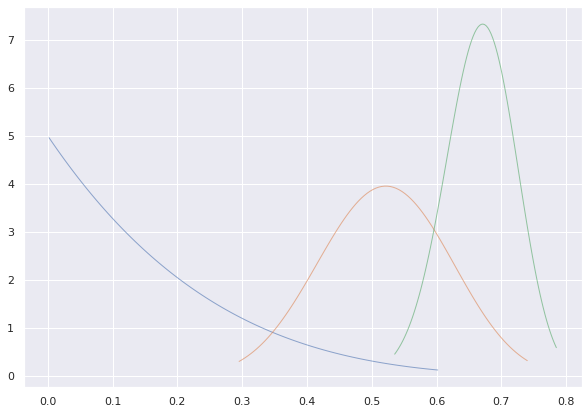

In [ ]:
plot_pdf(agent._alpha, agent._beta)

In [ ]:
environment = BannerEnvironment([0.85, 0.4, 0.15])
step = environment.reset()

#agent = BannerAgent()

df_trajectory = run(environment, agent, trials=100)

print(f'\nalpha={agent._alpha}, beta={agent._beta}')
print(f'mu={beta.stats(agent._alpha, agent._beta)[0]}')


alpha=[30, 17, 55], beta=[10, 25, 69]
mu=[0.75       0.4047619  0.44354839]


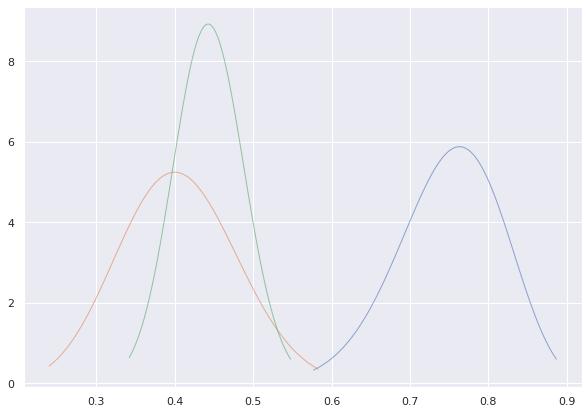

In [ ]:
plot_pdf(agent._alpha, agent._beta)

**Úkol**: Vyřešit, aby při změně environmentu agent rychleji reagoval.